# Interpretability

- Data load and preparation

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier, plot_tree
import optuna
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import PartialDependenceDisplay
from sklearn.metrics import mean_squared_error

In [79]:
#de mateo
#de mateo
#de mateo
dfFeature = pd.read_csv(r'pruebaData.csv')
dfFeature.drop(columns=['Complain'], inplace= True)

X = dfFeature.drop('Exited', axis=1)
y = dfFeature['Exited']

# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

ValueError: numpy.dtype size changed, may indicate binary incompatibility. Expected 96 from C header, got 88 from PyObject

INTRINSICALLY INTERPRETABLE MODELS:

First, we are going to analyze the interpretability of some classification models we have used, which are Logistic Regression and Decision Trees. The objective is to determine which of the variables have more impact in the outcome 

- Logistic Regression

In [2]:
#de mateo
#de mateo
#de mateo
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

def objective(trial):
    solver = trial.suggest_categorical("solver", ["lbfgs", "liblinear", "saga","sag"])
    C = trial.suggest_float("C", 1e-6, 1e2, log =True)
    max_iter = trial.suggest_int('max_iter', 100, 5000)
    model = LogisticRegression(
        solver=solver,
        C=C,
        random_state=42,
        class_weight='balanced',
        max_iter= max_iter
    )
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train_scaled, y_train, cv=skf, scoring="roc_auc", n_jobs=-1).mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective,n_trials=500, n_jobs=-1)
print("Best hyperparameters:", study.best_params)

[I 2024-12-21 21:52:01,933] A new study created in memory with name: no-name-c922edba-297c-49b3-b862-c5ea3b01b1a6
[I 2024-12-21 21:52:04,239] Trial 2 finished with value: 0.7889271990060771 and parameters: {'solver': 'liblinear', 'C': 1.552786789090123e-05, 'max_iter': 3805}. Best is trial 2 with value: 0.7889271990060771.
[I 2024-12-21 21:52:04,305] Trial 8 finished with value: 0.7935905461759976 and parameters: {'solver': 'lbfgs', 'C': 0.000300718158136363, 'max_iter': 4764}. Best is trial 8 with value: 0.7935905461759976.
[I 2024-12-21 21:52:04,340] Trial 4 finished with value: 0.7961047278751047 and parameters: {'solver': 'liblinear', 'C': 2.80474813413759, 'max_iter': 2115}. Best is trial 4 with value: 0.7961047278751047.
[I 2024-12-21 21:52:04,343] Trial 9 finished with value: 0.7961191744276757 and parameters: {'solver': 'saga', 'C': 0.0801841317170117, 'max_iter': 4065}. Best is trial 9 with value: 0.7961191744276757.
[I 2024-12-21 21:52:04,354] Trial 1 finished with value: 0.7

Best hyperparameters: {'solver': 'saga', 'C': 0.04498569985948202, 'max_iter': 2417}


In [3]:
best_params = study.best_params
logistic_model = LogisticRegression(
    solver=best_params["solver"],
    C=best_params["C"],
    random_state=42,
    class_weight='balanced',
    max_iter=best_params["max_iter"]
)

logistic_model.fit(X_train_scaled, y_train)
#Score
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
logistic_score = cross_val_score(logistic_model, X_train_scaled, y_train, cv=skf, scoring="roc_auc", n_jobs=-1).mean()
print(logistic_score)

0.7961427704635416


In [4]:
coefs_log = logistic_model.coef_
intercept_log = logistic_model.intercept_
print('coefficients: %s' % coefs_log)
print('intercept: %s' % intercept_log)

coefficients: [[-0.07078105 -0.01185382  0.07119789 -0.42782369 -0.01853434 -0.41112972
   0.03856551 -0.01583265 -0.05132527  0.14376085 -0.14376085 -0.1462992
   0.26157544 -0.09328121  0.03098596 -0.02272382 -0.00612737 -0.00189096
  -0.29956915  0.26890838  0.47809347 -0.37376017  0.15467074]]
intercept: [-0.37897634]


In [5]:
# Feature Importance
coef_df = pd.DataFrame({'feature': X_train.columns.values, 'coef': coefs_log[0]})
coef_df

,feature,coef
0,CreditScore,-0.070781
1,Tenure,-0.011854
2,Balance,0.071198
3,NumOfProducts,-0.427824
4,HasCrCard,-0.018534
5,IsActiveMember,-0.411130
6,EstimatedSalary,0.038566
7,Satisfaction Score,-0.015833
8,Point Earned,-0.051325
9,Gender_Female,0.143761


In [6]:
#Standardized
stdv = np.std(X_train, 0)
abs(coefs_log.reshape(23,) * stdv).sort_values(ascending=False)

Balance               4435.934185
EstimatedSalary       2214.627889
Point Earned            11.602656
CreditScore              6.843824
NumOfProducts            0.213883
IsActiveMember           0.205451
Age_30-40                0.148586
Age_<30                  0.138690
Age_50-60                0.134831
Age_40-50                0.117563
Geography_Germany        0.113454
Geography_France         0.073150
Gender_Female            0.071540
Gender_Male              0.071540
Geography_Spain          0.040304
Age_>60                  0.034882
Tenure                   0.034261
Satisfaction Score       0.022328
Card Type_DIAMOND        0.013370
Card Type_GOLD           0.009901
HasCrCard                0.008431
Card Type_PLATINUM       0.002652
Card Type_SILVER         0.000817
dtype: float64

- Decision Tree

In [7]:
#de mateo
#de mateo
#de mateo
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 1000)
    max_depth = trial.suggest_int("max_depth", 3, 50)
    min_samples_split = trial.suggest_int("min_samples_split", 2, 32)
    min_samples_leaf = trial.suggest_int("min_samples_leaf", 1, 32)
    max_features = trial.suggest_categorical("max_features", ["sqrt", "log2", None])
    model = DecisionTreeClassifier(
        max_depth=max_depth,
        min_samples_split=min_samples_split,
        min_samples_leaf=min_samples_leaf,
        random_state=42,
        class_weight="balanced", 
    )

    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train, y_train, cv=skf, scoring="roc_auc", n_jobs=-1).mean()
    return score

study = optuna.create_study(direction="maximize", sampler=optuna.samplers.RandomSampler(seed=42))
study.optimize(objective, n_trials=50, n_jobs=-1)

print("Best hyperparameters:", study.best_params)

[I 2024-12-21 21:52:26,527] A new study created in memory with name: no-name-8bcf8029-03c0-4309-b465-fedcbecccc32
[I 2024-12-21 21:52:26,781] Trial 2 finished with value: 0.73075791430305 and parameters: {'n_estimators': 198, 'max_depth': 24, 'min_samples_split': 31, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 2 with value: 0.73075791430305.
[I 2024-12-21 21:52:26,865] Trial 10 finished with value: 0.7307143338694609 and parameters: {'n_estimators': 570, 'max_depth': 3, 'min_samples_split': 21, 'min_samples_leaf': 27, 'max_features': 'log2'}. Best is trial 2 with value: 0.73075791430305.
[I 2024-12-21 21:52:26,923] Trial 0 finished with value: 0.764307865666323 and parameters: {'n_estimators': 908, 'max_depth': 36, 'min_samples_split': 19, 'min_samples_leaf': 16, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.764307865666323.
[I 2024-12-21 21:52:26,965] Trial 1 finished with value: 0.6543385405129489 and parameters: {'n_estimators': 342, 'max_depth': 42, 'min_

Best hyperparameters: {'n_estimators': 516, 'max_depth': 6, 'min_samples_split': 27, 'min_samples_leaf': 16, 'max_features': None}


In [ ]:
best_params = study.best_params
decision_tree = DecisionTreeClassifier(
    max_depth=best_params["max_depth"],
    min_samples_split=best_params["min_samples_split"],
    min_samples_leaf=best_params["min_samples_leaf"],
    random_state=42,
    class_weight="balanced",
)
decision_tree.fit(X_train, y_train)
#Score
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
decision_score = cross_val_score(decision_tree, X_train, y_train, cv=skf, scoring="roc_auc", n_jobs=-1).mean()
print(decision_score)

0.7891142818618716


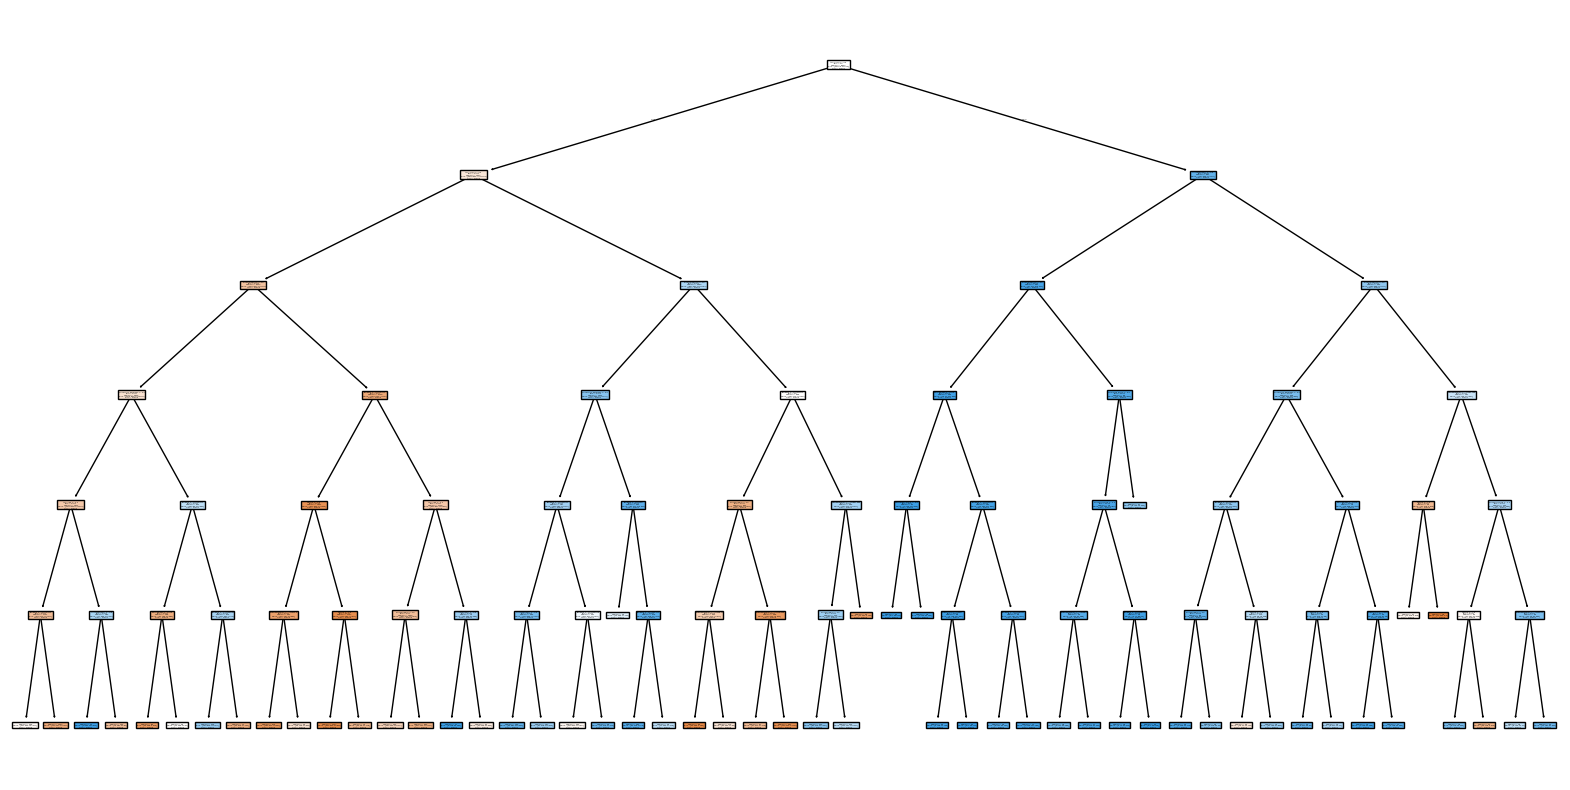

In [ ]:
plt.figure(figsize=(20,10))
plot_tree(decision_tree, filled=True, feature_names=X.columns, class_names=['Class 0', 'Class 1'])
plt.show()

In [10]:
dt_imp_df = pd.DataFrame({'feature':X_train.columns.values.tolist(),
'importance': decision_tree.feature_importances_}).sort_values(by='importance', ascending=False)
dt_imp_df

,feature,importance
20,Age_50-60,0.225268
19,Age_40-50,0.206713
2,Balance,0.197102
3,NumOfProducts,0.117041
5,IsActiveMember,0.075992
12,Geography_Germany,0.063366
22,Age_>60,0.045338
6,EstimatedSalary,0.024473
1,Tenure,0.018193
10,Gender_Male,0.015876


Now we will interprate the results given by both models:

    Logistic Regression:

 -Most possitively influential variables:  'Age_50-60' (0.47), 'Age_40-50' (0.26) and 'Geography_Germany' (0.26)

 -Most negatively influential variables: NumOfProducts (-0.42), 'IsActiveMember'(-0.41) and 'Age_<30' (-0.37)

 -Most influential standardized variables: 'Balance' (4435.93) and 'EstimatedSalary' (2214.62)

The logistic regression model (79.61%) indicates that age and geography, as well as the balance and the estimated salary are really important for the model's predictions.

We can see that age categories follow a clear pattern, the old customers with higher balance, have the highest chance to exit on the outcome, while the young and inactive customer is the least likely to exit.

Also, If we compare 'Gender_Female' (0.14) and 'Gender_Male' (-0.14), we can se that male customers have a negative influence and females are possitively influential in this case, showing that females are more likely to exit and males to stay. Also, German people seem to be specially predisposed to exiting banks. 

The negative intercept (-0.37) means that if there is no influence, customers are less likely to exit. But this is not relevant in out case because variables like age are practically never 0.

    Decision Tree

The decision tree model (78.91%) suggests that it's most important features are 'Age_50-60' (0.22), 'Balance' (0.19), 'Age_40-50' (0.19) and 'NumOfProducts' (0.10). The rest have low or 0 relevance. In conclussion, the decision tree model supports our logistic regression model's conclussions which are the most important factors.

GLOBAL MODEL AGNOSTIC METHODS

The second step is to understand which is the way our models work, for that we are going to use PDP and ALE:

- Partial Dependence Plot (PDP)

For this section, we are going to apply PDP to the most influential variables of the decision tree model

Text(0.5, 0.98, 'Partial Dependence Plots - Decision Tree')

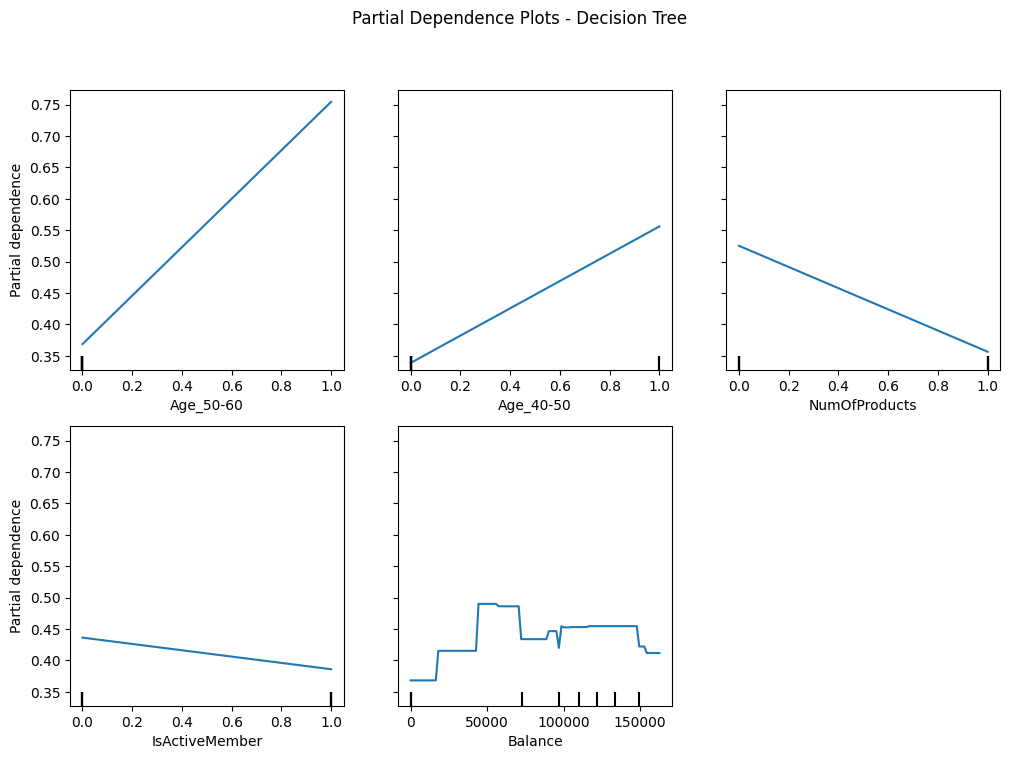

In [ ]:
features = ["Age_50-60", "Age_40-50","NumOfProducts", "IsActiveMember", "Balance"]

fig, ax = plt.subplots(figsize=(12, 8))
display = PartialDependenceDisplay.from_estimator(decision_tree, X_train, features, kind="average", ax=ax)
display.figure_.suptitle("Partial Dependence Plots - Decision Tree")

- Accumulated Local Effects (ALE)

In [89]:
from alibi.explainers import ALE, plot_ale
#problemas con la libreria alibi, no es compatible con numpy, y desconfigura otras librerias
features = ["Age_50-60", "Age_40-50","NumOfProducts", "IsActiveMember", "Balance"]

logisticALE = ALE(logistic_model.predict, feature_names=features)
decisionTreeALE = ALE(decision_tree.predict, feature_names=features)

logisticExp = logisticALE.explain(X_train)
decisionTreeExp = decisionTreeALE.explain(X_train)

# Plot ALEs
plot_ale(decisionTreeExp, n_cols=4, fig_kw={'figwidth': 14, 'figheight': 7})
logisticMSE = mean_squared_error(y_test, logistic_model.predict(X_test))
print(f"Logistic Regression MSE: {logisticMSE}")

ImportError: cannot import name 'ALEExplainer' from 'interpret.ext.blackbox' (c:\Users\dekum\AppData\Local\Programs\Python\Python312\Lib\site-packages\interpret\ext\blackbox\__init__.py)

In [ ]:
plot_ale(decisionTreeExp, n_cols=4, fig_kw={'figwidth': 14, 'figheight': 7})
decisionTreeMSE = mean_squared_error(y_test, decision_tree.predict(X_test))
print(f"Random Forest MSE: {decisionTreeMSE}")

    PDP

The result suggests that firstly, for both 'Age_50-60' and 'Age_40-50', as the value increases (it can only be 0 or 1), the chances of exit prediction also increases, although its less pronounced for the 40-50 age varaible, the effects is really similar. Also, it seems like the 'NumOfProducts' variable has almost the contrary effect on the model if we compare it with 'Age_40-50', and much the same happens with 'isActiveMember', but less strongly.  

Secondly, the relation between the 'Balance' variable's value, and the changes of exit prediction change, not as in the previous case. So, as well as we know that this variable is really important for the model's predictions, now we know that the way this variable is considered for the model's prediction is not linear, as we could have guessed → (Higher balance = + chances of exit).

    ALE

In this case,

Overall, we can see that PDP supports the conclussions we have made for the 'intrinsically interpretable model' step's results, but also, giving some really interesting insights, on how each of the most important variables in the model affect the prediction.

